In [101]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt

In [102]:
batch_size=64
epochs=100
latent_dim=256
num_samples=10000
data_path='fra.txt'

In [103]:
input_texts=[]
target_texts=[]
input_characters=set()
target_characters=set()

with open(data_path,'r',encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines)-1)]:
    input_text, target_text, _ = line.split('\t')
    target_text= '\t'+target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    for char in input_text:
        if char not in input_characters: input_characters.add(char)
    
    for char in target_text:
        if char not in target_characters: target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

input_token_index = dict(
    [(char,i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char,i) for i, char in enumerate(target_characters)])

In [104]:
encoder_input_data = np.zeros(
    (len(input_texts),max_encoder_seq_length,num_encoder_tokens), dtype='float32')

decoder_input_data = np.zeros(
    (len(input_texts),max_decoder_seq_length,num_decoder_tokens), dtype='float32')

decoder_target_data = np.zeros(
    (len(input_texts),max_decoder_seq_length,num_decoder_tokens), dtype='float32')

In [105]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1
    encoder_input_data[i, t+1:, input_token_index[' ']] = 1
    
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1
    decoder_target_data[i, t:, target_token_index[' ']] = 1

In [106]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

In [107]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [108]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

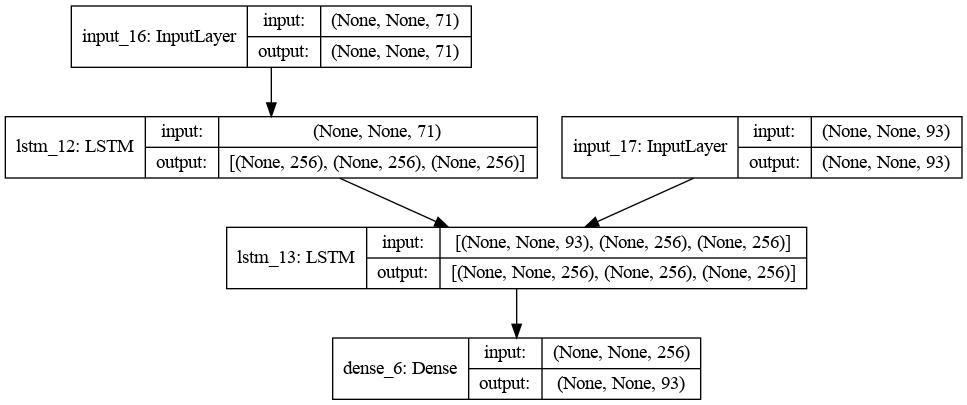

In [109]:
plot_model(model, show_shapes=True)

In [110]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [111]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 17s 2ms/step - loss: 1.1863 - accuracy: 0.7232 - val_loss: 1.0527 - val_accuracy: 0.7050
Epoch 2/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.8537 - accuracy: 0.7687 - val_loss: 0.9374 - val_accuracy: 0.7618
Epoch 3/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.6790 - accuracy: 0.8075 - val_loss: 0.7109 - val_accuracy: 0.7935
Epoch 4/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.5939 - accuracy: 0.8275 - val_loss: 0.6546 - val_accuracy: 0.8078
Epoch 5/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.5457 - accuracy: 0.8409 - val_loss: 0.6111 - val_accuracy: 0.8208
Epoch 6/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.5102 - accuracy: 0.8502 - val_loss: 0.5834 - val_accuracy: 0.8263
Epoch 7/100
8000/8000 [==============================] - 17s 2ms/step - loss

8000/8000 [==============================] - 17s 2ms/step - loss: 0.1067 - accuracy: 0.9666 - val_loss: 0.5534 - val_accuracy: 0.8751
Epoch 57/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.1043 - accuracy: 0.9674 - val_loss: 0.5581 - val_accuracy: 0.8738
Epoch 58/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.1024 - accuracy: 0.9679 - val_loss: 0.5704 - val_accuracy: 0.8741
Epoch 59/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.1000 - accuracy: 0.9685 - val_loss: 0.5646 - val_accuracy: 0.8754
Epoch 60/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.0979 - accuracy: 0.9691 - val_loss: 0.5787 - val_accuracy: 0.8740
Epoch 61/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.0957 - accuracy: 0.9697 - val_loss: 0.5773 - val_accuracy: 0.8747
Epoch 62/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.0943 - accuracy: 0.9701 - val_loss: 0.5772 - val_a

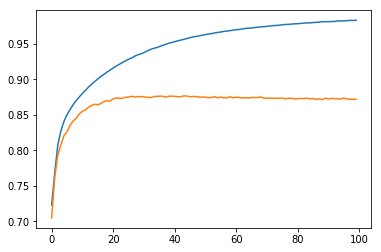

In [113]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])

In [114]:
encoder_model = Model(encoder_inputs, encoder_states)

In [115]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

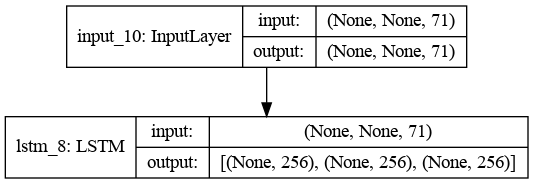

In [86]:
plot_model(encoder_model, show_shapes=True)

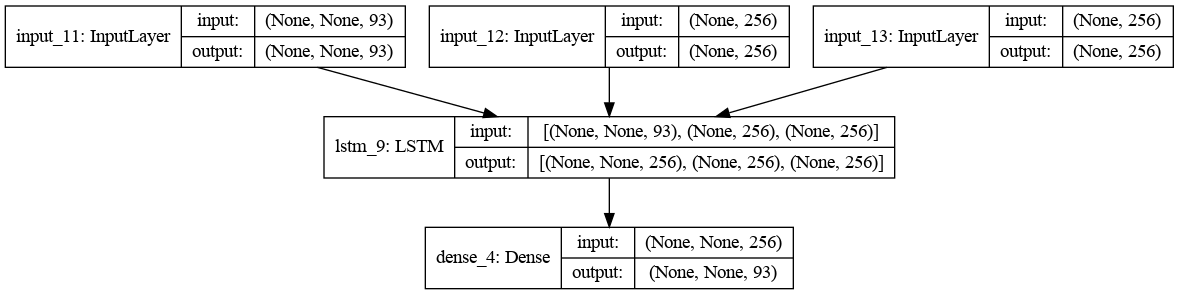

In [87]:
plot_model(decoder_model, show_shapes=True)

In [116]:
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [117]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1,num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1
    
    stop_condition = False
    decoded_sequence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sequence += sampled_char
        
        if (sampled_char == '\n' or len(decoded_sequence) > max_decoder_seq_length): stop_condition = True
        
        target_seq = np.zeros((1,1,num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
        
        states_value = [h, c]
    
    return decoded_sequence

In [118]:
for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print(input_texts[seq_index])
    print(decoded_sentence)

-
Go.
Va !

-
Hi.
Salut.

-
Hi.
Salut.

-
Run!
Courez !

-
Run!
Courez !

-
Who?
Qui ?

-
Wow!
Ça alors !

-
Fire!
Au feu !

-
Help!
À l'aide !

-
Jump.
Saute.

-
Stop!
Stop !

-
Stop!
Stop !

-
Stop!
Stop !

-
Wait!
Attends !

-
Wait!
Attends !

-
Go on.
Poursuis.

-
Go on.
Poursuis.

-
Go on.
Poursuis.

-
Hello!
Bonjour !

-
Hello!
Bonjour !

-
I see.
Je me suis dépêché.

-
I try.
J'essay.

-
I won!
Je l'ai emporté !

-
I won!
Je l'ai emporté !

-
I won.
J'ai perdu.

-
Oh no!
Oh non !

-
Attack!
Attaquez !

-
Attack!
Attaquez !

-
Cheers!
Santé !

-
Cheers!
Santé !

-
Cheers!
Santé !

-
Cheers!
Santé !

-
Get up.
Lève-toi.

-
Go now.
Vas-y maintenant.

-
Go now.
Vas-y maintenant.

-
Go now.
Vas-y maintenant.

-
Got it!
Compris !

-
Got it!
Compris !

-
Got it?
Pigé ?

-
Got it?
Pigé ?

-
Got it?
Pigé ?

-
Hop in.
Montez.

-
Hop in.
Montez.

-
Hug me.
Serre-moi dans tes bras !

-
Hug me.
Serre-moi dans tes bras !

-
I fell.
Je suis tombé.

-
I fell.
Je suis tombé.

-
I know.
Je sais.
